## Тематическое моделирование

Скачиваем датасет (источник): положительные, отрицательные.

или можно через ноутбук

!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

как альтернатива можно скачать данные из Роспотребнадзора
https://zpp.rospotrebnadzor.ru/Forum/Appeals
для этого берём ноутбук parse_rospotrebnadzor.ipynb
устанавливаем количество скачанных страниц больше не 50-сят хотябы 500 и для анализа берём только вопросы так как ответы есть не всегда

1. объединить в одну выборку (это только для твитов), для роспотребнадзора сформировать датасет из вопросов

In [3]:
# Импорт библиотек

import requests
from bs4 import BeautifulSoup 
import time
from urllib.parse import urlparse, urljoin
from tqdm.notebook import tqdm

In [4]:
## найти id каждого вопроса на страницах
page = 1
main_url = 'https://zpp.rospotrebnadzor.ru/Forum/Appeals/AjaxindexList?page={page}&searchtext=&categories=[]'

def ids_from_page(soup):
    return [i.get('href') for i  in soup.findAll('a', {'class':'appeal-title-link'})]
    
urls = []
for page in tqdm(range(1, 1000), desc='Pages'):
    time.sleep(0.5)
    res = requests.get(main_url.format(page=page))  
    soup = BeautifulSoup(res.text)
    urls.extend(ids_from_page(soup))

In [5]:
## имея id запросов достанем тексты на страницах
domain = 'https://zpp.rospotrebnadzor.ru'

def get_text_page_question(soup):
    return soup.findAll('p', {'class':'appeal-details-message'})[0].text
def get_text_page_answer(soup):
    return soup.findAll('p', {'class':'appeal-comments-message'})[0].text

question = []
answers = []

for url in tqdm(urls, desc='Pages'):
    time.sleep(0.5)
    res = requests.get(urljoin(domain, url))  
    soup = BeautifulSoup(res.text)
    
    question.append(get_text_page_question(soup))
    try:
        answers.append(get_text_page_answer(soup))
    except:
        answers.append('No answer')

In [46]:
# Импорт библиотек

import pandas as pd
import numpy as np
import re
import string
from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words
import nltk
from nltk.tokenize import word_tokenize

/Users/evgeniya/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
# Создание датасета из вопросов

df = pd.DataFrame(data = question, columns = ['question'])

df.sample(3)

/Users/evgeniya/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,question
2775,Здравствуйте. Прошу вас замерить гул в квартир...
738,Добрый день. 22.02.2022 мною был оплачен товар...
1564,Возврат товара надлежащего качества. Куплен 14...


In [48]:
# Препроцессинг текста

stopwords = set(get_stop_words("ru") + ['здравствуйте', 'добрый', 'день', 'вопрос', 'роспотребнадзор', 'либо', 'месяц', 'течение', 'данный'])
morpher = MorphAnalyzer()

def preprocess_txt(line):
    line = line.lower() # Нижний регистр
    line = re.sub(r'[^\w\s]', ' ', line) # Пунктуация
    line = re.sub(" \d+", " ", line) # Числа
    words = word_tokenize(line) # Токенизация
    words = [morpher.parse(word)[0].normal_form for word in words] # Лемматизация
    words = [word for word in words if len(word)>3] # Слова длинной меньше 3 символов
    words = [word for word in words if word not in stopwords] # Стоп слова
   
    return words

/Users/evgeniya/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:9: DeprecationWarning: invalid escape sequence \d
<>:9: DeprecationWarning: invalid escape sequence \d
<ipython-input-48-72a9725eab1b>:9: DeprecationWarning: invalid escape sequence \d
  line = re.sub(" \d+", " ", line) # Числа
/Users/evgeniya/opt/anaconda3/lib/python3.8/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/Users/evgeniya/opt/anaconda3/lib/python3.8/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargs

In [49]:
df.question.iloc[1]

/Users/evgeniya/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'Ведётся продажа контрафакта г.к Анапа ул Астраханская 104 около табриса магазин заполнен контрафактной продукцией '

In [50]:
print(preprocess_txt(df.question.iloc[1]))

['вестись', 'продажа', 'контрафакт', 'анапа', 'астраханский', 'табрис', 'магазин', 'заполнить', 'контрафактный', 'продукция']


/Users/evgeniya/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
preprocessed_text = list(tqdm(map(preprocess_txt, df['question']), total=len(df)))

/Users/evgeniya/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
df['clean_text'] = preprocessed_text
df.sample(3)

/Users/evgeniya/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,question,clean_text
3362,"УК Коммунальщик ул. Рабочая, 13 а. все сотрудн...","[коммунальщик, рабочий, сотрудник, ходить, мас..."
4579,Добрый день! Правомерно ли запрещение присутст...,"[правомерно, запрещение, присутствие, родитель..."
2084,Добрый день.\r\n\r\n10.11.2021г. был сделан за...,"[сделать, заказ, платформа, яндекс, маркет, ст..."


2. провести исследование и выявить тематики о которых говорят в твитах (для твитов), а для роспотребнадзора так же выявить тематики о которых люди пишут проанализировать

### Модель LDA

In [53]:
# Импорт библиотек

from gensim.models import *
from gensim import corpora
from gensim.models.phrases import Phraser

/Users/evgeniya/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [54]:
# Биграммы

bigram_mod = Phraser(bigram)

def bigrams(text):
    return [bigram_mod[doc] for doc in text]    

df['clean_text'] = bigrams(df['clean_text'])

/Users/evgeniya/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
# Создаем словарь

dictionary = corpora.Dictionary(df['clean_text'])

dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 
dictionary.save('rospotreb.dict')

/Users/evgeniya/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
# Векторизация документов

corpus = [dictionary.doc2bow(text) for text in df['clean_text']]
corpora.MmCorpus.serialize('rospotreb.model', corpus) 

/Users/evgeniya/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
# Обучение модели

%time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=20, chunksize=50, update_every=1, passes=2)

/Users/evgeniya/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 1.93 s, sys: 2.94 ms, total: 1.93 s
Wall time: 1.93 s


3. сделать визуализацию кластеров тематик

In [58]:
# !pip install pyLDAvis

/Users/evgeniya/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [59]:
# Импорт библиотек

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import matplotlib.pyplot as plt
%matplotlib inline

/Users/evgeniya/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
%time vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

/Users/evgeniya/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 568 ms, sys: 41.6 ms, total: 610 ms
Wall time: 742 ms


In [61]:
# Перплексия и когерентность

coherence_model_lda = CoherenceModel(model=lda, texts=df['clean_text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))
print('Средняя когерентность: ', coherence_lda)

/Users/evgeniya/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Персплексия:  4.867548804354599e-08
Средняя когерентность:  0.3339847110988049


/Users/evgeniya/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


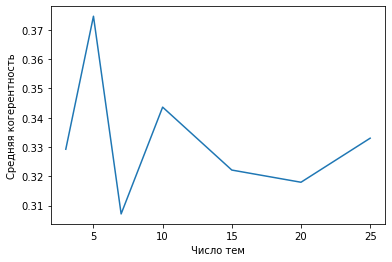

In [62]:
# Подбор количества тем

topics_list = [3, 5, 7, 10, 15, 20, 25]
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=df['clean_text'], dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

In [63]:
# Обучаем модель с новым количеством тем

lda_15 = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=5, chunksize=50, update_every=1, passes=2)
vis_data = gensimvis.prepare(lda_15, corpus, dictionary)
pyLDAvis.display(vis_data)

/Users/evgeniya/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


4. проинтерпритировать получившиеся тематики

1. Слова: банк, заказ, сайт, интернет-магазин, доставка - вопросы, связанные с покупками в интернете.
2. Слова: водитель, документ, маска, тест, поездка - вопросы, связанные с поездками во время ковидных ограничений.
3. Слова: ремонт, телефон, телевизор, сервисный центр - вопросы, связанные с ремонтом техники
4. Слова: возврат, дефект, замена, качество - вопросы, связанные с заменой товара
5. Слова: результат, сдавать тест, врач, ковид - вопросы, связанные с тестированием на ковид